***
# 深層学習day3
***

## Section1: 再帰型ニューラルネットワークの概念

+ 時系列データに対応したニューラルネットワーク
+ 時系列データ
  + 時間的順序を追って一定間隔で観察できる
  + 相互に統計的依存関係あり
  + 株価データ・音声データ・テキストデータ（単語のつながり）・自然言語
  
**RNN**
+ 入力層⇒中間層⇒出力層という基本構造は変わらない
+ 時間的繋がりをうまく組み込む
+ ある時間の中間層の出力を次の時間の入力の一部に使う
+ 複数の中間層をまとめて表現すること理解しやすい

**順伝播**

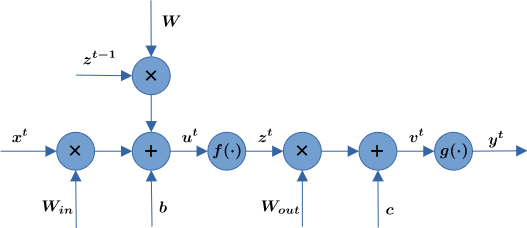

In [ ]:
display(img)

$$
u^{t} = x^{t}W_{in} + z^{t-1}W  + b \\
z^{t} = f( u^{t}) \\
v^{t} = z^{t} W_{out}  + c \\
y^{t} = g(v^{t})
$$
```python
u[:, t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
```
+ 2次元配列uのt+1列に値を代入
+ XとW_inの内積を計算
+ 2次元配列zのt列とWとの内積を計算  
  (t列を抽出した際に1次元配列となるのでreshapeで2次元配列に変換)

```python
z[:,t+1] = functions.sigmoid(u[:,t+1])
```
+ 2次元配列zのt+1列に値を代入
+ 2次元配列uのt+1列の値をシグモイド関数(f)で計算

```python
np.dot(z[:,t+1].reshape(1, -1), W_out)
y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
```
+ 2次元配列yのt列に値を代入
+ 2次元配列zのt+1列とW_outの内積を計算
+ 計算結果をシグモイド関数(g)で計算

### 【確認テスト】
RNNのネットワークには大きくわけて3つの重みがある。1つは入力から現在の中間層を定義する際にかけられる重み、1つは中間層から出力を定義する際にかけられる重みである。残り1つの重みについて説明せよ。  
【解答】  
過去の中間層から現在の中間層を定義する際にかけられる重み

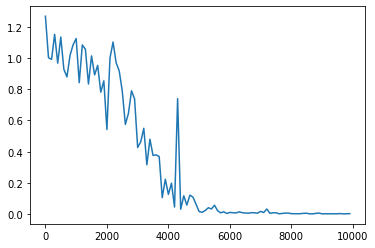

In [ ]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    

    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))

        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        #print("iters:" + str(i))
        #print("Loss:" + str(all_loss))
        #print("Pred:" + str(out_bin))
        #print("True:" + str(d_bin))
        #out_int = 0
        #for index,x in enumerate(reversed(out_bin)):
        #    out_int += x * pow(2, index)
        #print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        #print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()


【ソースコード分析】
+ 8桁の2進数を対象する
+ 10進数での表現できる値は2^8よりも小さい値(256-1=255)
+ binary: 0～255までの整数を値ごとのビット配列に変換した2次元配列
    + numpy.unpackbits関数  
    配列の符号なし整数の値を2進数に変換し各桁を要素とする配列を返す
+ 各種パラメータ
    + 入力層のノード: 2，隠れ層のノード: 16，出力層のノード: 1
    + 重み初期化の標準偏差: 1，学習率: 0.1，イテレーション数: 10000
+ 各重み配列初期化（確率分布は正規分布）
    + W_in: (2, 16), W_out: (16, 1), W: (16, 16)
+ 勾配計算結果用配列の生成
    + numpy.zeros_like関数  
    引数で渡した配列のshapeとdtypeを継承した各要素値0の配列を返す
    + W_in_grad: (2, 16), W_out_grad: (16, 1), W_grad: (16, 16)
+ 順伝播処理用配列の生成
    + u: (16, 9), z: (16, 9), y: (1, 8)
    zは次の桁へ渡す値があるので1列多い．uはzとインデックスを揃えるため1列多い
  
+ 逆伝播処理用配列の生成
    + delta_out: (1, 8) 出力層の勾配の一部計算結果
    + delta: (16, 9) 中間層の勾配の一部計算結果
+ 誤差を保持するリストを生成
    + all_losses
+ 学習
    + 2数をランダム生成しビット配列に
    + 2数の和をとり正解データビット配列を生成
    + 演算出力用のビット配列を0初期化
    + all_loss: 誤差計算結果保持用変数
      
    + 2数の桁ごとの演算処理(8桁分のループ)  
    処理はビット配列の1桁目から8桁目の順（配列インデックスの降順）に実施
        + X: 2数から処理する桁のビット値を抽出しサイズ(1, 2)の配列を生成
        + dd: 正解データの対応する桁のビット値を保持
        + u[:,t+1]: 中間層への入力演算結果(16, 1)を代入
        + z[:,t+1]: 中間層からの出力演算結果(16, 1)を代入
        + y[:,t]: 出力層での演算結果値を代入
          
        + loss: 予測値と正解データとの誤差を保持
        + delta_out[:,t]: 逆伝播処理用の勾配用計算値を代入
        + out_bin: 予測結果のビット値を0,1変換して代入  
          
    + 逆伝播処理  
    順伝播と逆方向の処理となるからビット配列の8桁目から1桁目に向かって処理する
      + X: 2数から処理する桁のビット値を抽出しサイズ(1, 2)の配列を生成
      + delta[:,t]: 順伝播で生成したdelta_out[:,t]とW_outとの内積と時間的に1つ先であるdelta[:,t+1]とWとの内積の和に活性化関数の勾配をかけたもの(16,1)を代入
      + 勾配の更新:　全時間に関数値の累計をとる
        + W_out_grad: z[:,t+1]とdelta_out[:,t]との内積を加算
        + W_grad: z[:,t]とdelta[:,t]との内積を加算
        + W_in_grad: Xとdelta[:,t]との内積を加算
    + 重みの更新: 逆伝播のループ後の勾配データに学習率をかけた値を減算
    + 勾配の初期化
  

### 【演習チャレンジ】
以下は再帰型ニューラルネットワークにおいて構文木を入力として再帰的に文全体の表現ベクトルを得るプログラムである。ただし、ニューラルネットワークの重みパラメータはグローバル変数として定義してあるものとし、_activation関数はなんらかの活性化関数であるとする。木構造は再帰的な辞書で定義してあり、rootが最も外側の辞書であると仮定する。  
【解答】  
ベクトルの要素は単語を表すので，単語（要素）の特徴が保持され続ける必要があるよって，  
（2）W.dot(np.concatenate([left, right]))  
この処理により要素数は増加するが，重みのサイズを調整することで要素数を調整できる

**BPTT**

$$
u^{t} = x^{t}W_{in} +z^{t-1} W  + b \\
z^{t} = f( u^{t}) \\
v^{t} =  z^{t} W_{out} + c \\
y^{t} = g(v^{t})
$$

各変数偏微分(f, g はシグモイド関数)
$$
E = \frac{1}{2}(y^{t} - d^{t})^2 ~~,~~
\frac{\partial E}{\partial y^{t}} = y^{t} - d^{t} ~~,~~
\frac{\partial y^{t}}{\partial v^{t}} = g(v^{t})\{1-g(v^{t})\}\\
\frac{\partial v^{t}}{\partial z^{t}} = W_{out} ~~, ~~
\frac{\partial v^{t}}{\partial W_{out}} = z^{t} ~~,~~
\frac{\partial v^{t}}{\partial c} = 1 ~~, ~~
\frac{\partial z^{t}}{\partial u^{t}} = f(u^{t})\{1-f(u^{t})\} \\
\frac{\partial u^{t}}{\partial x^{t}} = W_{in} ~~,~~
\frac{\partial u^{t}}{\partial W_{in}} = x^{t} ~~,~~
\frac{\partial u^{t}}{\partial z^{t-1}} = W ~~,~~
\frac{\partial u^{t}}{\partial W} = z^{t-1} ~~,~~
\frac{\partial u^{t}}{\partial b} = 1
$$
ここで，
$$
\delta_{out}^{t} \equiv \frac{\partial E}{\partial v^{t}} ~~,~~ 
\delta^{t} \equiv \frac{\partial E}{\partial u^{t}}
$$
とすると，
$$
\frac{\partial E}{\partial W_{out}} =\frac{\partial E}{\partial v^{t}}\frac{\partial v^{t}}{\partial W_{out}} = \delta_{out}^{t} z^{t} ~~,~~
\frac{\partial E}{\partial W} =\frac{\partial E}{\partial v^{t}}\frac{\partial v^{t}}{\partial W} = \delta_{out}^{t} z^{t-1} \\
\frac{\partial E}{\partial W_{in}} =\frac{\partial E}{\partial u^{t}}\frac{\partial u^{t}}{\partial W_{in}} = \delta^{t} x^{t} \\
\frac{\partial E}{\partial b} = \frac{\partial E}{\partial u^{t}}\frac{\partial u^{t}}{\partial b} = \delta^{t} ~~, ~~ 
\frac{\partial E}{\partial c} = \frac{\partial E}{\partial v^{t}}\frac{\partial v^{t}}{\partial c} = \delta_{out}^{t}
$$

δとzについて，計算の経路が1つの場合，
$$
\delta^{t} = \frac{\partial E}{\partial u^{t}} ~~, ~~z^{t} = f( u^{t})
$$
から，t=t-1とて，連鎖律を適用すると
$$
\delta^{t-1} = \frac{\partial E}{\partial u^{t-1}}=
  \frac{\partial E}{\partial u^{t}}\frac{\partial u^{t}}{\partial u^{t-1}}= \frac{\partial E}{\partial u^{t}}\frac{\partial u^{t}}{\partial z^{t-1}}\frac{\partial z^{t-1}}{\partial u^{t-1}}\\
z^{t-1} = f( u^{t-1})
$$
と表すことができる．ここで，
$$
u^{t} = x^{t}W_{in} +z^{t-1} W  + b 
$$
より，
$$
\frac{\partial u^{t}}{\partial z^{t-1}} = W
$$
また，
$$
\frac{\partial z^{t-1}}{\partial u^{t-1}} = f'( u^{t-1})
$$
であるから，
$$
\delta^{t-1}= \frac{\partial E}{\partial u^{t}}\frac{\partial u^{t}}{\partial z^{t-1}}\frac{\partial z^{t-1}}{\partial u^{t-1}} = \delta^{t}\{Wf'(u^{t-1})\}
$$
さらに拡張して，t=t-zとおくと
$$
\delta^{t-z -1}= \delta^{t-z}\{Wf'(u^{t-z-1})\}
$$
と表すことができる．    
  

また，計算経路に分岐がある場合は，
$$
\begin{eqnarray}
\delta^{t-1} &=& \frac{\partial E}{\partial u^{t-1}} = \frac{\partial E}{\partial z^{t-1}} \frac{\partial z^{t-1}}{\partial u^{t-1}} \\
&=& \left\{ \frac{\partial E}{\partial v^{t-1}}\frac{\partial v^{t-1}}{\partial z^{t-1}} + 
\frac{\partial E}{\partial u^{t}}\frac{\partial u^{t}}{\partial z^{t-1}}
\right\}\frac{\partial z^{t-1}}{\partial u^{t-1}} \\
&=& \left( \delta_{out}^{t-1} W_{out} + \delta^{t} W \right)f'(u^{t-1})
\end{eqnarray} 
$$
と表すことができる．


**重みの更新**  
+ W_outとcは計算グラフの経路に分岐がないので，基本的なニューラルネットワークと同じ
$$
  W_{out}^{t+1} =  W_{out}^{t} - \epsilon \delta_{out}^{t}[z^{t}]^T \\
  c^{t+1} = c^{t} - \epsilon \delta_{out}^{t}
$$
+ W_inとWとbは計算グラフの経路に時間的な接続があるので過去の勾配も加える必要がある
$$
W_{in}^{t+1} = W_{in}^{t} - \epsilon \sum_{z=0}^{\tau}\delta^{t-z}[x^{t-z}]^T \\
W^{t+1} = W^{t} - \epsilon \sum_{z=0}^{\tau}\delta^{t-z}[z^{t-z-1}]^T \\
b^{t+1} = b^{t} - \epsilon \sum_{z=0}^{\tau}\delta^{t-z}
$$

### 【確認テスト】
下図のy1をx・s0・s1・Win・W・Woutを用いて数式で表せ。  
※バイアスは任意の文字で定義せよ。  
※また中間層の出力にシグモイド関数g(x)を作用させよ。

$$
s^{(1)} = x^{(1)} W_{in}  + s^{(0)} W  + b \\
y^{(1)} = g \left(s^{(1)} W_{out}  + c \right)
$$

###【コード演習問題】
BPTTを行うプログラムである。なお簡単化のため活性化関数は恒等関数であるとする。また、calculate_dout関数は損失関数を出力に関して偏微分した値を返す関数であるとする。？にあてはまるのはどれか
```python
for t in reversed(range(n_seq)):
  dV += np.dot(do[:, t].T, hiddens[:, t]) / batch_size
  delta_t = do[:, t].dot(V)

  for bptt_step in reversed(range(t+1)):
    dW += np.dot(delta_t.T, xs[:, bptt_step]) / batch_size
    dU += np.dot(delta_t.T, hiddens[:, bptt_stap-1]) / batch_size
    delta_t = ?????????????????????
return dW, dU, dV
```
【解答】  
講義のサンプルコードと比較すると
dWがW_in_grad相当，dUがW_grad相当，dVがW_out_grad相当  
delta_tはdelta相当  
ここで活性化関数を恒等関数とすると
$$
\delta^{t-1}= \frac{\partial E}{\partial u^{t}}\frac{\partial u^{t}}{\partial z^{t-1}}\frac{\partial z^{t-1}}{\partial u^{t-1}} = \delta^{t} W \cdot 1
$$
よってW相当のUを使って
```python
delta_t.dot(U)
```

【参考文献】
1. 岡谷貴之著『深層学習』講談社　2015.04
2. 斎藤康毅著『セロから作るDeepLearning2 自然言語処理編』オライリー・ジャパン 2018.07
3. 巣籠悠輔著『詳解ディープラーニング 第2版』マイナビ出版 2019.11
4. 竹縄知之 東京海洋大学大学院講義科目「深層学習」Part4 http://www2.kaiyodai.ac.jp/~takenawa/learning/lecture_Part4.pdf
5. RNN モデルを Python で実装して簡単な数列を解かせてみた。 https://qiita.com/MomonekoView/items/ad2cff722a07825eedd7
6. 再帰型ニューラルネット in 機械学習プロフェッショナルシリーズ輪読会 https://www.slideshare.net/shotarosano5/chapter7-50542830

## Section2: LSTM
+ RNNの問題：時系列を遡ると勾配が消失する⇒LSTM
+ 勾配爆発: 層を逆伝播するほどに指数関数的に勾配が増加⇒クリッピング
+ 勾配の時間変化が1であれば消失も爆発もしない⇒CEC

### 【演習チャレンジ】
RNNや深いモデルでは勾配の消失または爆発が起こる傾向がある。勾配爆発を防ぐために勾配のクリッピングを行うという手法がある。具体的には勾配のノルムがしきい値を超えたら、勾配のノルムをしきい値に正規化するというものである。以下は勾配のクリッピングを行う関数である。？にあてはまるのはどれか。
```python
def gradient_clipping(grad, threshold):
  norm = np.linalg.norm(grad)
  rate = threshold / norm
  if rate < 1:
    return ????????????
  return grad
```
+ numpy.linalg.norm関数  
  引数のベクトルのノルムを返す（デフォルトはL2ノルム）  

【解答】  
クリッピングは勾配ベクトルのノルムがある閾値を超えた場合に閾値で正規化するので，  正規化項はrate = threshold / norm　だから
```python
grad * rate
```

+ CEC(Constant Error Carousel)  
  + RNNでは中間層で学習し，結果を記憶する
  + 学習と記憶を分離させCECでは記憶を担当
  + 1より小さい勾配によって勾配消失が発生
  + 1より大きい勾配によって勾配爆発が発生
  + 勾配1で学習できるように調整する機能を別に用意
+ 入力ゲート・出力ゲート・忘却ゲート
  + 今回の入力値と前回の出力値が制御パラメータ
  + 入力ゲート：過去の記憶をどのように再帰に利用するかを制御
  + 出力ゲート：現在の記憶をどのように出力に利用するかを制御
  + 忘却ゲート：記憶(CEC)の消去を制御する
+ 覗き穴結合
  + 記憶だけに利用しているCECの値を学習に利用
    + 入力ゲート・忘却ゲートには過去の値を伝達
    + 出力ゲートには現在の値を伝達

### 【確認テスト】
以下の文章をLSTMに入力し空欄に当てはまる単語を予測したいとする。文中の「とても」という言葉は空欄の予測においてなくなっても影響を及ぼさないと考えられる。このような場合、どのゲートが作用すると考えられるか。  
<br>
「映画おもしろかったね。ところで、とてもお腹が空いたから何か____。」

【解答】  
学習に必要としない情報は消去する⇒忘却ゲート

### 【演習チャレンジ】
以下のプログラムはLSTMの順伝播を行うプログラムである。ただし_sigmoid関数は要素ごとにシグモイド関数を作用させる関数である。？にあてはまるのはどれか。
```python
def lstm(x, prev_h, prev_c, W, U, b):
  lstm_in = _activation(x.dot(W.T) + prev_h.dot(U.T) + b)
  a, i, f, o = np.hsplit(lstm_in, 4)

  a = np.tanh(a)
  input_gate = _sigmoid(i)
  forget_gate = _sigmoid(f)
  output_gete = _sigmoid(o)

  c = ??????????????????????
  h = output_gate * np.tanh(c)

  return c, h
```
【解答】  
hの定義式よりcは出力に向かう活性化関数の引数であるから，CECからの出力
$$
c(t) = i(t)a(t)+f(t)c(t-1)
$$
より，
```python
input_gate * a + forget_gate * c
```

## Section3: GRU 
+ LSTMはパラメータ数が多く計算負荷が大⇒パラメータ数を削減
+ リセットゲート・更新ゲート
  + 今回の入力値と前回の出力値がパラメータ
  + CECとCEC出力の活性化処理がない
  + 出力には前回の出力zと今回の入力(1-z)との比率の合計が1になる



### 【確認テスト】
LSTMとCECが抱える課題について、それぞれ簡潔に述べよ。  
【解答】  
LSTMはパラメータ数が多く計算負荷が大きい．  
CECには学習能力がないので別に学習機能を設ける必要がある  
⇒入力ゲート・出力ゲート・忘却ゲート  



### 【演習チャレンジ】
GRU(Gated Recurrent Unit)もLSTMと同様にRNNの一種であり、単純なRNNにおいて問題となる勾配消失問題を解決し、長期的な依存関係を学習することができる。LSTMに比べ変数の数やゲートの数が少なく、より単純なモデルであるが、タスクによってはLSTMより良い性能を発揮する。以下のプログラムはGRUの順伝播を行うプログラムである。ただし_sigmoid関数は要素ごとにシグモイド関数を作用させる関数である。？にあてはまるのはどれか。
```python
def gru(x, h, W_r, U_r, W_z, U_z, W, U):
  r = _sigmoid(x.dot(W_r.T) + h.dot(U_r.T))
  z = _sigmoid(x.dot(W_z.T) + h.dot(U_z.T))

  h_bar = np.tanh(x.dot(W.T) + (r*h).dot(U.T))
  h_new = ?????????????????????????
  return h_new
```
【解答】  
関数の戻り値がh_newであるからh_newはGRUの出力となる．  
出力は今回の入力からの演算h_barと前回の出力hが(1-z)とzの比率で足し合わされる．
```python
(1 - z) * h_bar + z * h
```
**※ 原著論文を確認したところ論文と本講義資料では(1-z)とzが逆であった**


### 【確認テスト】
LSTMとGRUの違いを簡潔に述べよ。  
【解答】  
+ LSTMは計算結果を記憶するCECと学習処理を制御する入力ゲート・出力ゲート・忘却ゲートから構成されている
+ GRUには計算結果を記憶する部分はなく，学習処理を制御するリセットゲートと更新ゲートで構成されている
+ GRUの方が構成要素が少ないのでパラメータ数が少なく計算負荷が少ない

【参考文献】
1. 岡谷貴之著『深層学習』講談社　2015.04
2. 斎藤康毅著『セロから作るDeepLearning2 自然言語処理編』オライリー・ジャパン 2018.07
3. 巣籠悠輔著『詳解ディープラーニング 第2版』マイナビ出版 2019.11
4. 竹縄知之 東京海洋大学大学院講義科目「深層学習」Part4 http://www2.kaiyodai.ac.jp/~takenawa/learning/lecture_Part4.pdf
5. Cho et al. 2014. Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation. In Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing, pages 1724–1734. 

## Section4: 双方向RNN
+ 過去の情報だけでなく，未来の情報も利用したRNN
+ 文章の翻訳などに利用
+ 事前に先の文章も判っている
+ 過去から未来へのRNNと未来から過去へのRNNを組み合わせる



### 【演習チャレンジ】
以下は双方向RNNの順伝播を行うプログラムである。順方向については、入力から中間層への重みW_f, 一ステップ前の中間層出力から中間層への重みをU_f、逆方向に関しては同様にパラメータW_b, U_bを持ち、両者の中間層表現を合わせた特徴から出力層への重みはVである。_rnn関数はRNNの順伝播を表し中間層の系列を返す関数であるとする。？にあてはまるのはどれか
```python
def budurectuibak_rnn_net(xs, W_f, U_f, Wb, U_b, V):
  xs_f = np.zeros_like(xs)
  xs_b = bo,zeris_like(xs)

  for i, x in enumerate(xs):
    xs_f[i] = x
    xs_b[i] = x[::-1]
  
  hs_f = _rnn(xs_f, W_f, U_f)
  hs_b = _rnn(xs_b, W_b, U_b)
  hs = [ ??????????????????? for h_f, h_b in zip(hs_f, hs_b)]
  ys = hs.dot(V.T)
  return ys
```
【解答】  
関数内のループ処理では過去→未来の時系列データと未来→過去の時系列データを生成している  
hs_fは過去→未来の時系列データのRNN処理結果を保持
hs_bは未来→過去の時系列データのRNN処理結果を保持
出力演算に渡す時系列データは過去→未来と未来→過去の2つを結合したものになるが，未来→過去の時系列データは逆順になっているので再度逆順にして元に戻す．  
2つの時系列データを時刻ごとに結合する必要があるので，列方向でconcatenate関数を使う  
```python
np.concatenate([h_f, h_b[::-1]], axis=1)
```

【参考文献】
1. 斎藤康毅著『セロから作るDeepLearning2 自然言語処理編』オライリー・ジャパン 2018.07
2. 巣籠悠輔著『詳解ディープラーニング 第2版』マイナビ出版 2019.11

## Section5: Seq2Seq
+ 機械翻訳で利用されている
+ 2つのRNNから構成されている
  + 単語列をRNNに入力すると学習結果が蓄積される→文の意味を抽出：エンコーダ
  + 文の意味を入力して翻訳結果を出力：デコーダ
+ エンコーダRNN：文の意味を集約
  + 全単語を入力し終わると隠れ層に文全体の意味がベクトルとして保持される
  + 各単語にIDを付番し，one-hotベクトルで表現
  + embedding表現で次元削減
  + MLM(Masked Language Model)：周りの単語から隠した位置に入る単語を学習する
  + 文の中の隠す単語を変えることで学習データを増やすことができる
+ デコーダRNN：エンコーダRNNで生成された意味ベクトルから新たな文を生成  
　+ 意味ベクトルを元に1単語を確率的に生成
  + その単語を元に次の単語を確率的に生成する処理の繰り返し



### 【確認テスト】
下記の選択肢から、seq2seqについて説明しているものを選べ。  
（1）時刻に関して順方向と逆方向のRNNを構成し、それら2つの中間層表現を特徴量として利用するものである。⇒双方向RNN  
（2）RNNを用いたEncoder-Decoderモデルの一種であり、機械翻訳などのモデルに使われる。⇒seq2seq  
（3）構文木などの木構造に対して、隣接単語から表現ベクトル（フレーズ）を作るという演算を再帰的に行い（重みは共通）、文全体の表現ベクトルを得るニューラルネットワークである。⇒構文木  
（4）RNNの一種であり、単純なRNNにおいて問題となる勾配消失問題をCECとゲートの概念を導入することで解決したものである。⇒LSTM  


### 【演習チャレンジ】
機械翻訳タスクにおいて、入力は複数の単語から成る文（文章）であり、それぞれの単語はone-hotベクトルで表現されている。Encoderにおいて、それらの単語は単語埋め込みにより特徴量に変換され、そこからRNNによって（一般にはLSTMを使うことが多い）時系列の情報をもつ特徴へとエンコードされる。以下は、入力である文（文章）を時系列の情報をもつ特徴量へとエンコードする関数である。ただし_activation関数はなんらかの活性化関数を表すとする。？にあてはまるのはどれか。
```python
def encode(words, E, W, U, b):
  hidden_size = W.shape[0]
  h = np.zeors(hidden_size)
  for w in words:
    e = ??????????????????
    h = _activation(W.dot(e) + U.dot(h) + b)
  return h
```
【解答】  
変数wordsはone-hotベクトルを要素とする配列だから，ループの変数wはone-hotベクトルである．seq2seqのエンコーダでは活性化関数に通す前にembedding表現にする処理が入るのでembedding行列Eとwの演算でembed_sizeの要素数の配列を作る必要がある．  
E:(embed_size, vocab_size) と　w:(vocab_size,)の演算で(embed_size)となるものは
```python
E.dot(w)
```
内積の演算よりも
```python
E[:, argmax(w)]
```
の方が計算量が少ないか？

+ HRED  
seq2seqは入力に対して1つの応答しか生成できない  
⇒今までの文脈から応答にバリエーションをつけたい
  + 文の意味ベクトルを入力とするRNN構造⇒seq2seq+contextRNN
  + ありがちな解答しかできない
+ VHRED
  + HREDにバリエーション加える手法
+ オートエンコーダ
  + 教師なし学習の一種
  + エンコーダで変換しデコーダで復元
  + 次元削減が可能
+ VAE(Variational Auto Encoder)
  + 次元圧縮の際に確率を持ち込む
  + ガウス分布ノイズを付加

【参考文献】
1. 斎藤康毅著『セロから作るDeepLearning2 自然言語処理編』オライリー・ジャパン 2018.07
2. 巣籠悠輔著『詳解ディープラーニング 第2版』マイナビ出版 2019.11
3. Aurélien Géron著、長尾 訳『scikit-learnとTensorFlowによる実践機械学習』オライリー・ジャパン 2018.04

## Section6: Word2vec
+ 単語をベクトル表現に変換する手法
+ one-hotベクトルからembedding表現使い意味の近いベクトルに変換（次元削減）
+ この変換表を機械学習で学習させる

## Section7: Attention Mechanism
+ seq2seqは長い文章に対応できない
  + 単語数が大きく違っていても中間層で生成する意味ベクトルの大きさは同じ
+ 文の中で重要な単語を学習できる⇒意味ベクトルに重要単語の影響度が高まる

### 【確認テスト】
RNNとword2vec、seq2seqとAttentionの違いを簡潔に述べよ。  
【解答】  
RNN：時系列データを学習するニューラルネットワークモデル  
word2vec：文を単語に分割して文の意味の類似性を表現できるベクトルに変換  
seq2seq：ある時系列データから別の時系列データを生成する方法  
attention：文章において重要単語を強調して学習できる手法

### 【確認テスト】
seq2seqとHRED、HREDとVHREDの違いを簡潔に述べよ。  
【解答】  
seq2seq：時系列データから別の時系列データを生成する方法  
HRED：seq2seqとコンテキストの時系列データの学習を合わせてバリエーションのある結果を生成しようとした  
VHRED：HREDにVAEの手法と取り入れることで生成に確率的な要素が加味され出力に幅ができるようになった
